# 1- Importation et préparation des données

In [38]:
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import statistics as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
import os

print(os.getcwd())

data_temperature = pd.read_table('../data/geneve-/TG_STAID000241.txt', sep = ',',
                                names = ['SOUID','DATE','TG','Q_TG'], skiprows = range(0,20), index_col = 1)
print(data_temperature.head())
data_temperature.drop(data_temperature[ data_temperature['Q_TG'] == 9 ].index, inplace = True)
data_temperature['Year'] = [int(str(d)[:4]) for d in data_temperature.index]
data_temperature['Month'] = [int(str(d)[4:6]) for d in data_temperature.index]
data_temperature['Day'] = [int(str(d)[6:8]) for d in data_temperature.index]

#Compute the day of the year for each year
day_of_year = np.array(len(data_temperature['Day']))

adate = [datetime.strptime(str(date),"%Y%m%d") for date in data_temperature.index]
data_temperature['Day_of_year'] = [d.timetuple().tm_yday for d in adate]

/home/luca/projects/SCV_project1/notebooks
           SOUID  TG  Q_TG
DATE                      
19010101  100745  49     0
19010102  100745  28     0
19010103  100745  -2     0
19010104  100745 -51     0
19010105  100745 -69     0


In [39]:
df = data_temperature

# 2- Analyse exploratoire des données comme des Time Series

## 2.1- Seasonal Plot of temperature

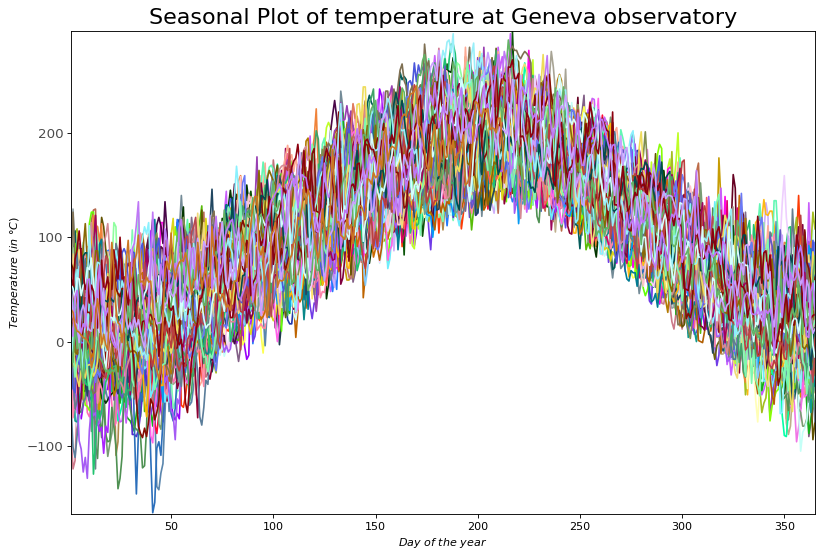

In [40]:
df1 = df
years = df1['Year'].unique()
# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(12,8), dpi= 80)

for i, y in enumerate(years):        
    plt.plot('Day_of_year','TG',data=df1[df1.Year==y], color=mycolors[i], label=y)
        

# Decoration
plt.gca().set(xlim=(1, 365), ylim=(min(df1.TG) - 1, max(df1.TG) + 1),
              ylabel='$Temperature\ (in\ °C)$', xlabel='$Day\ of\ the\ year$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of temperature at Geneva observatory", fontsize=20)
plt.show()

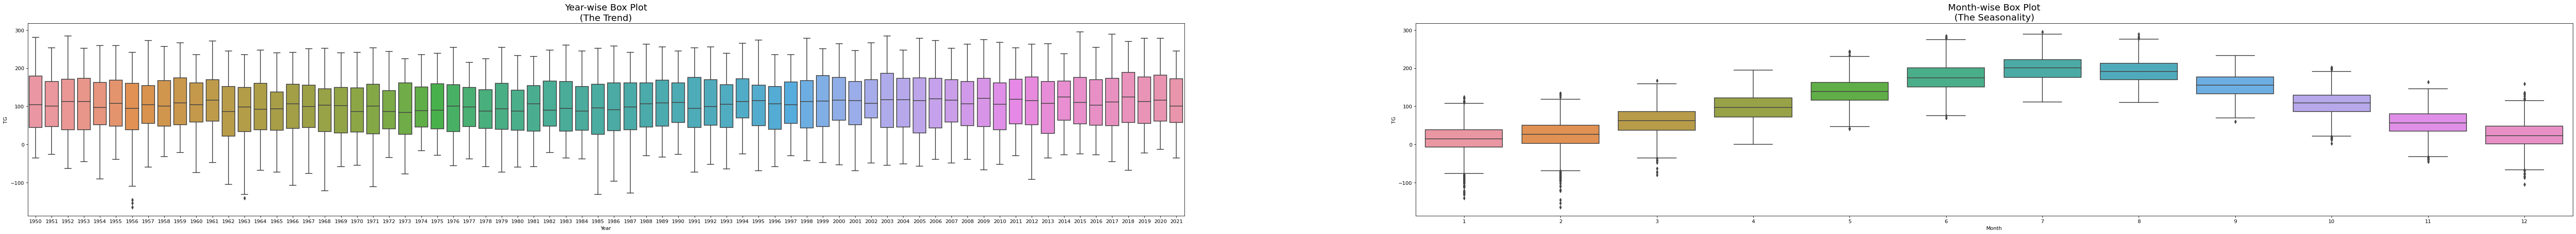

In [41]:
df1 = df[df.Year >= 1950]
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(90,7), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df1, ax=axes[0])
sns.boxplot(x='Month', y='TG', data=df1)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

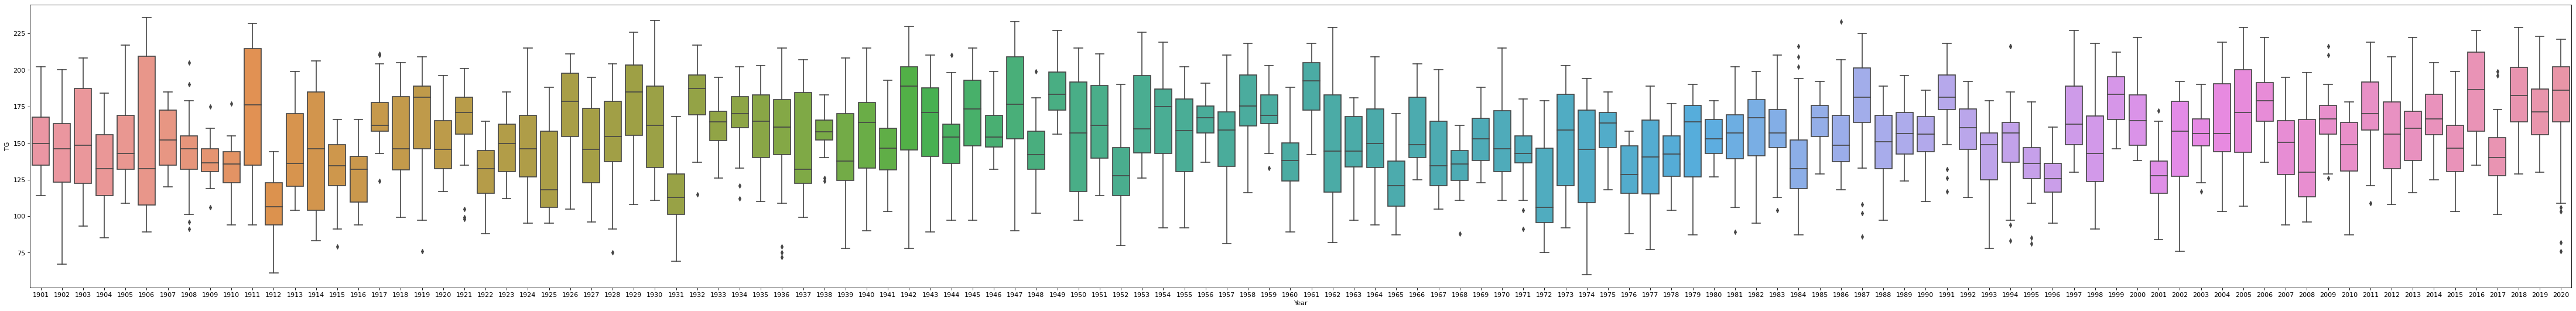

In [42]:
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
sns.boxplot(x='Year', y='TG', data=df[df.Month == 9] )

#plt.plot(years,[st.mean(df.TG[df.Year == year]) for year in years])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

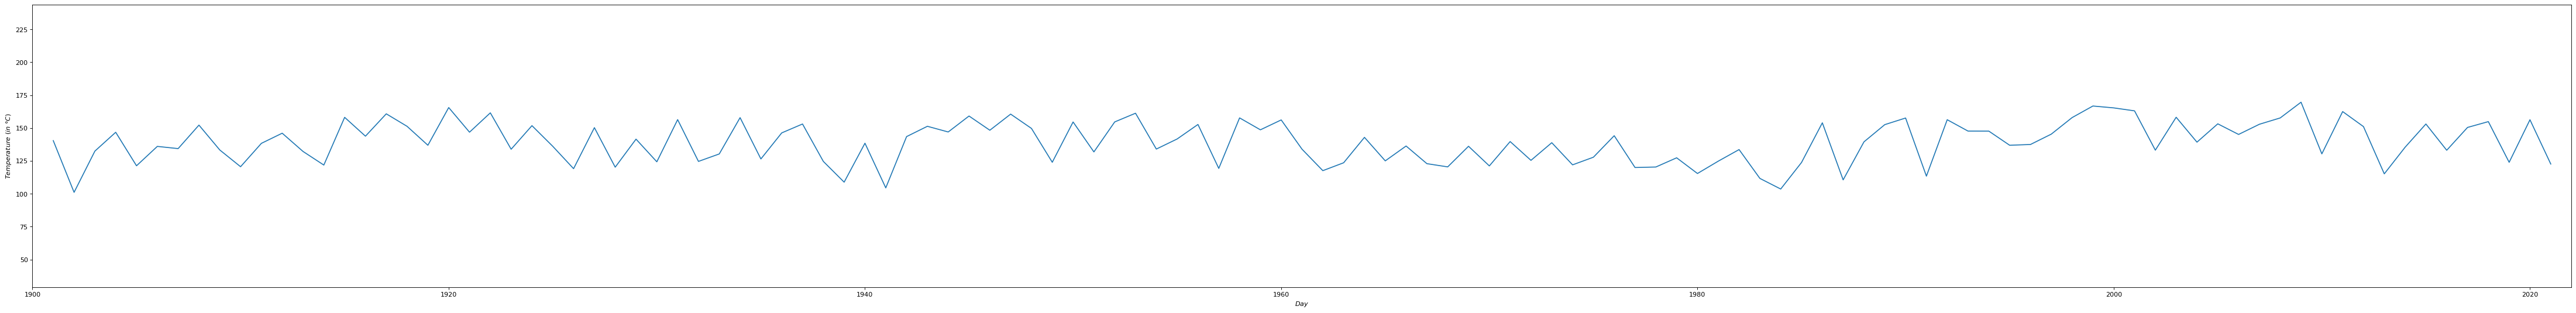

In [43]:
years = df['Year'].unique()
# Draw Plot
plt.figure(figsize=(70,8), dpi= 80)
month = 5
plt.plot(years,[st.mean(df.TG[(df.Year == year) & (df.Month == month)]) for year in years])

# Set Title
plt.gca().set(xlim=(1900, 2022), ylim=(min(df.TG[df.Month == month]), max(df.TG[df.Month == month])),
              ylabel='$Temperature\ (in\ °C)$', xlabel='$Day$')
plt.show()

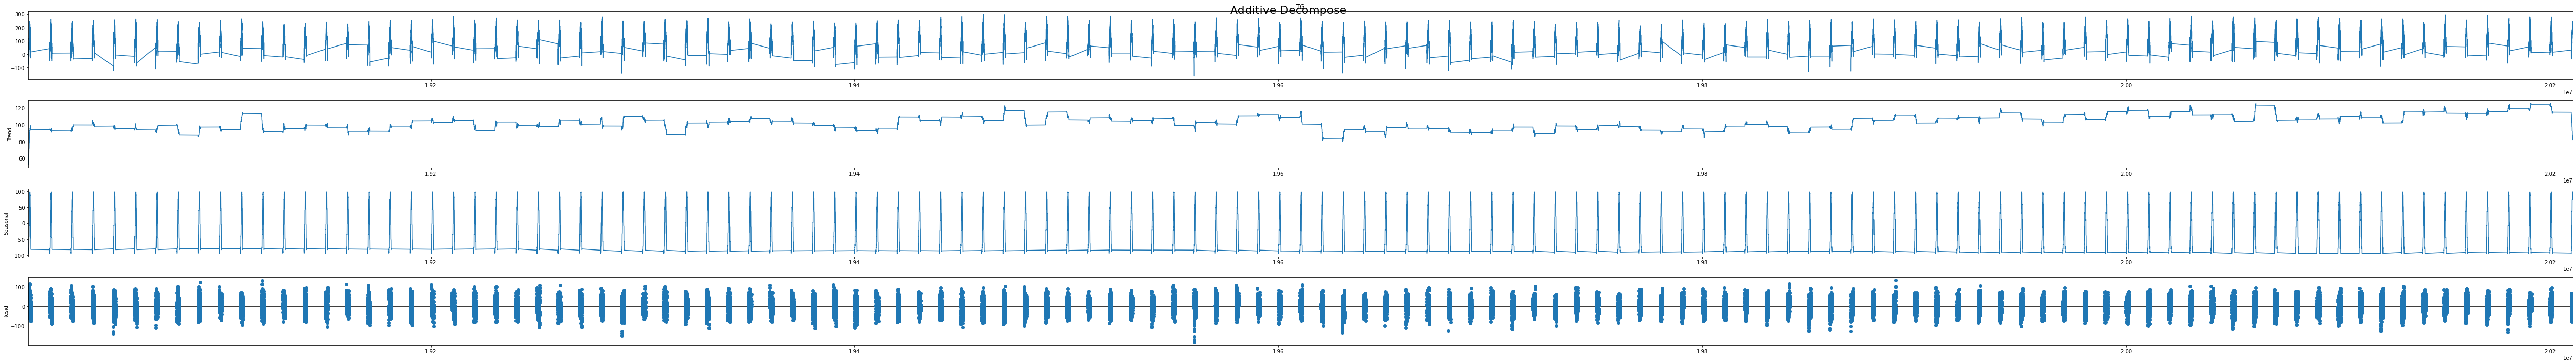

In [44]:
# Additive Decomposition
result_add = seasonal_decompose(df['TG'], model='additive', extrapolate_trend=7, period = 365,two_sided=True)

plt.rcParams.update({'figure.figsize': (70,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show() 

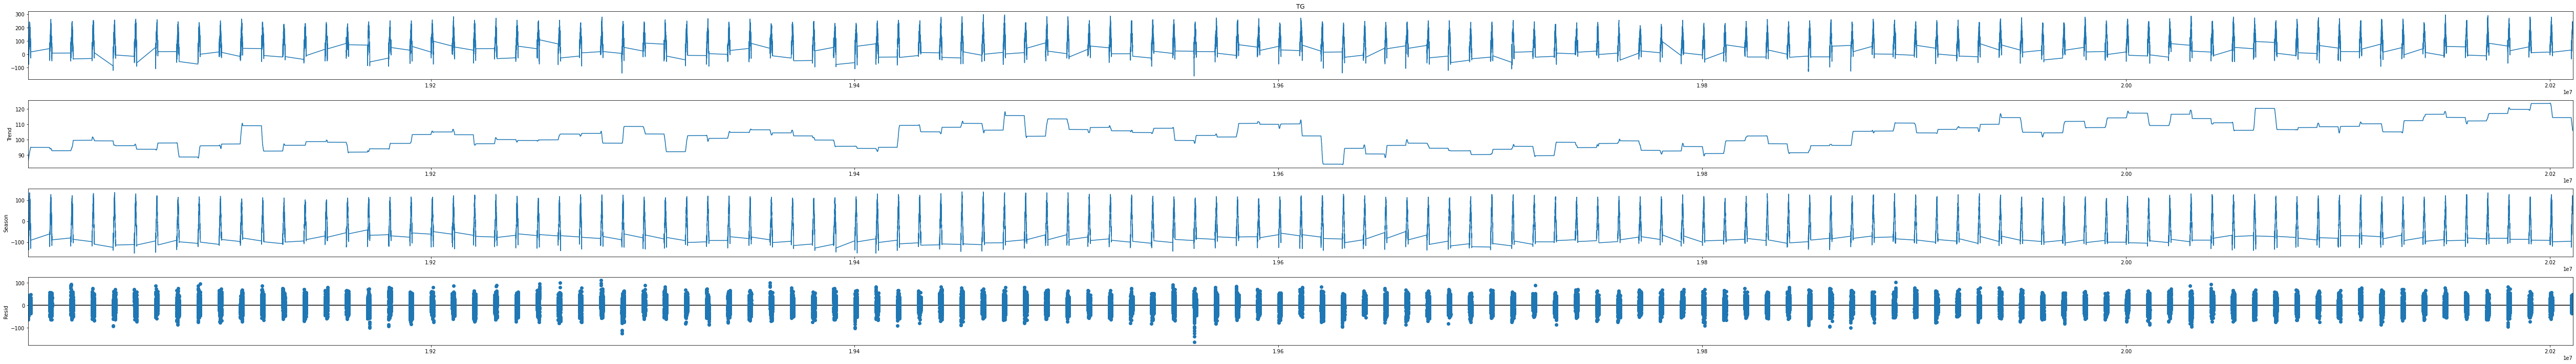

In [45]:
res = STL(df.TG, period = 365).fit()
res.plot()
plt.show()


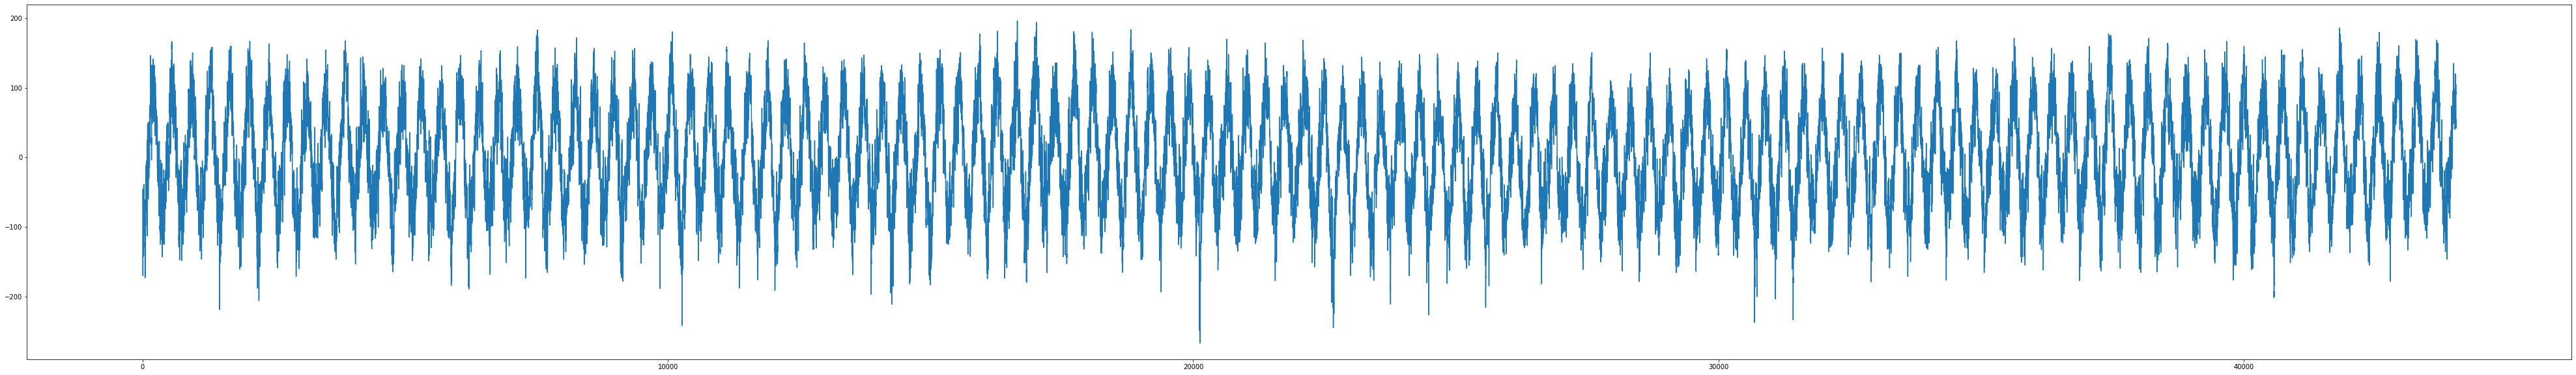

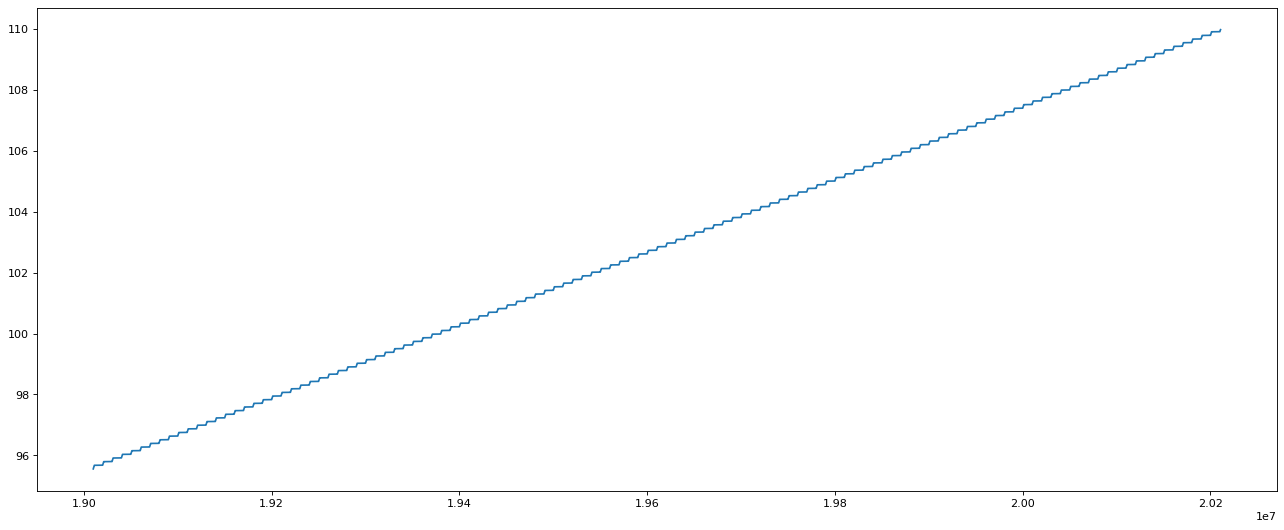

In [46]:
# Using scipy: Subtract the line of best fit
detrended1 = sc.signal.detrend(df.TG)
trend1 = df.TG - detrended1

plt.plot(detrended1)
plt.show()
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(trend1)
plt.show()

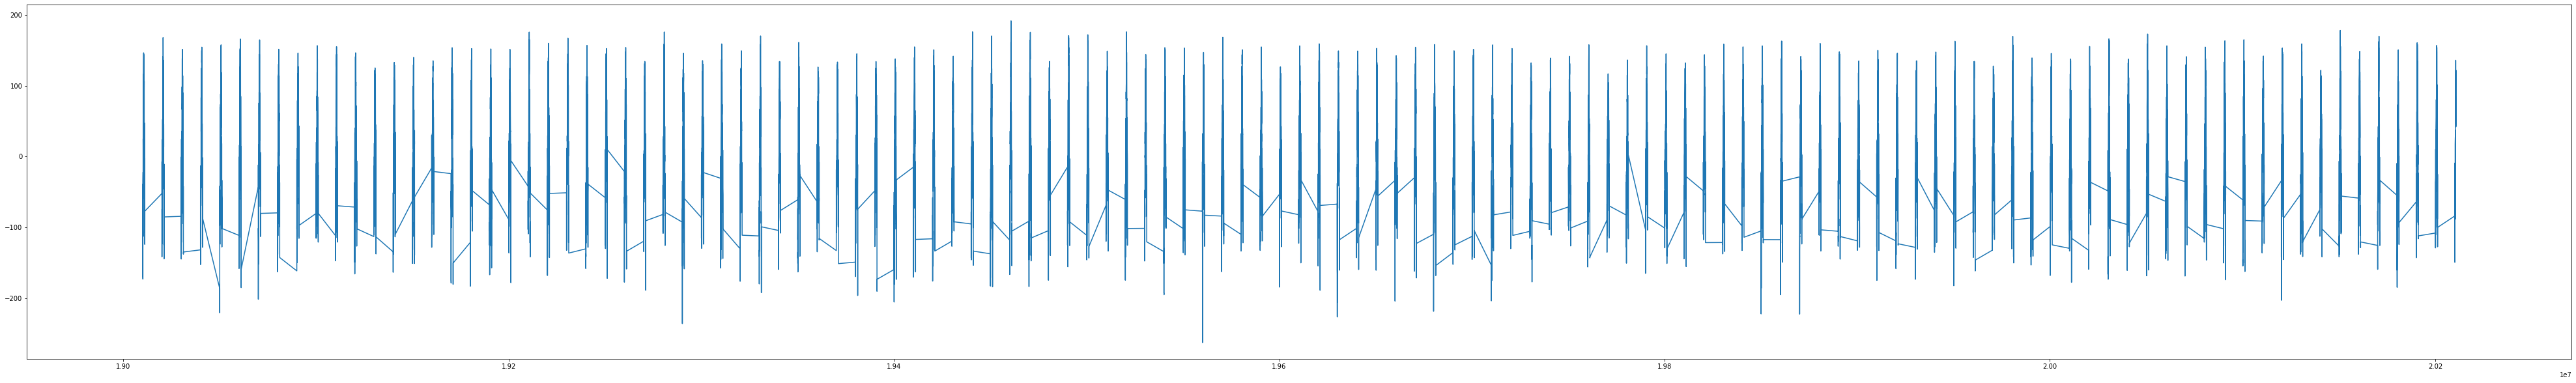

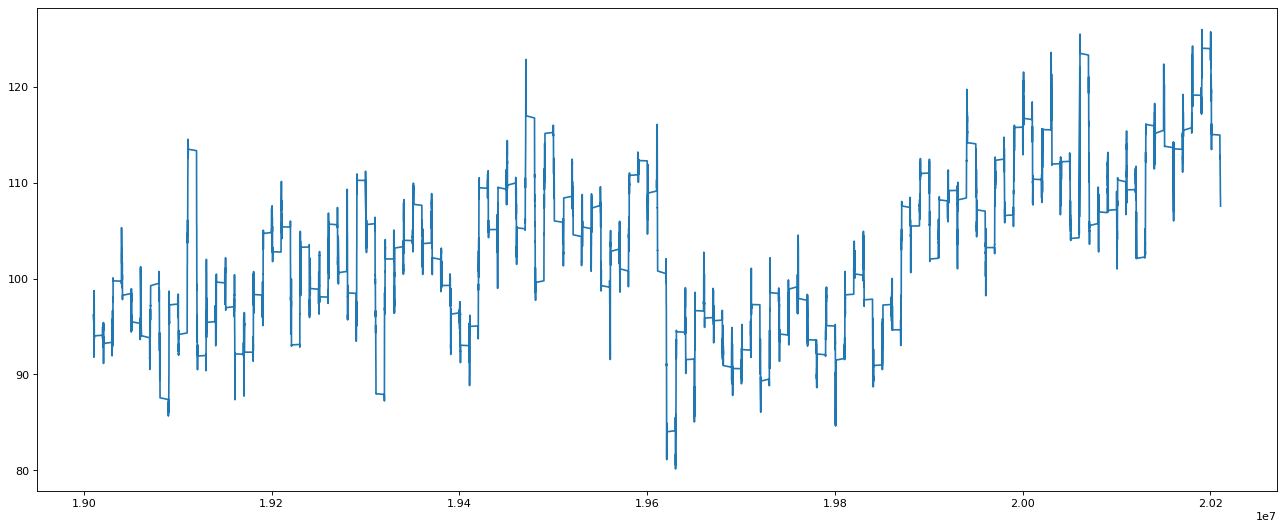

In [47]:
# Using statmodels: Subtracting the Trend Component.

result_add = seasonal_decompose(df.TG, model='additive', extrapolate_trend='freq',period = 365)
detrended = df.TG - result_add.trend
plt.plot(detrended)
plt.figure(figsize=(20,8), dpi= 80)
plt.plot(df.TG-detrended)


[ 1.          0.95946865 -0.04057756  0.16709001  0.08676412  0.07871117]


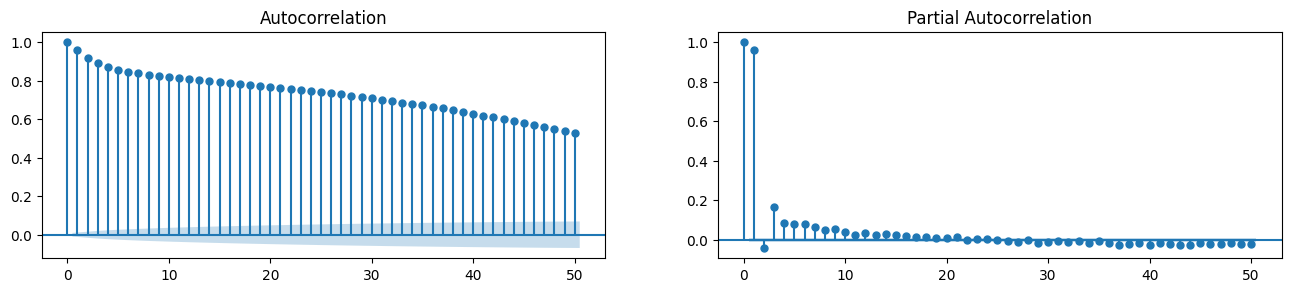

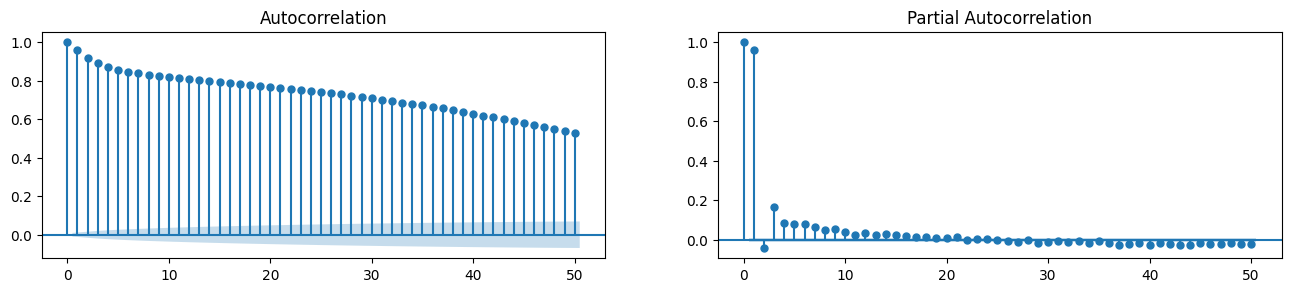

In [48]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
pacf_50 = pacf(df.TG, nlags=50)
print(pacf_50[:6])
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.TG, lags=50, ax=axes[0])
plot_pacf(df.TG, lags=50, ax=axes[1])

In [49]:
arma_mod = ARIMA(df.TG, order=(5, 0, 0)).fit()
print(arma_mod.params)

/usr/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


const     102.764190
ar.L1       0.983656
ar.L2      -0.195797
ar.L3       0.094777
ar.L4       0.008869
ar.L5       0.078910
sigma2    409.928233
dtype: float64
